## What do we *want* the CLASP case to match? 
Ideally, the CLASP approach of representing heterogeneity should come close to the mean of a case where you have a single atmospheric column over each land surface type. To replicate that situation, we run a series of SCAM simulations, prescribing just one surface type at a time. The mean of those simulations (area weighted to match the actual SGP gridcell) is somehwere near the "truth", or at least what we want to represent. <br><br>
<b>Date</b>: 22 March 2021

In [24]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
#import regionmask
import pickle
import scipy.stats as stats
import glob
import Ngl
import Nio 
import metpy.calc as mpc
from metpy.units import units


## Read in data

In [2]:
dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/SingleLandType/'

fileStart = 'FSCAM.T42_T42.arm97.clasp_useAndre_noMomentsWithCTSMmods-64lev-irrig-srfFlxAvg_startDay0531.SrfMod-'
camEnd    = '.cam.h0.2015-05-31-00000.nc'
clmEnd    = '.clm2.h0.2015-05-31-00000.nc'

sfcTypes = np.asarray(['BareGroundOnly','C3grassOnly','C4grassOnly', 'DeciduousTreeOnly', 'EvergreenTreeOnly',
                       'HighDensityUrbanOnly', 'IrrigCropOnly', 'MedDensityUrbanOnly', 'RainCropOnly'])


In [4]:
## Read everything into a single dataset (one for either CAM or CLM)
for iSfc in range(len(sfcTypes)):
    fileName_CAM = dataDir+fileStart+sfcTypes[iSfc]+camEnd
    fileName_CLM = dataDir+fileStart+sfcTypes[iSfc]+clmEnd

    with xr.open_dataset(fileName_CAM, decode_times=True) as camDS:
        camDS = camDS.expand_dims({"sfcType": 1})
    
    with xr.open_dataset(fileName_CLM, decode_times=True) as clmDS:
        clmDS = clmDS.expand_dims({"sfcType": 1})
    
    if iSfc==0:
        camDS_full = camDS
        clmDS_full = clmDS
    else:
        camDS_full = xr.concat([camDS_full, camDS], "sfcType")
        clmDS_full = xr.concat([clmDS_full, clmDS], "sfcType")

# Fill out sfcType 
camDS_full['sfcType'] = sfcTypes
clmDS_full['sfcType'] = sfcTypes

## Limit analysis to throw away the first day (spin up) 
camDS_full['time']  = camDS_full.indexes['time'].to_datetimeindex()
clmDS_full['time']  = clmDS_full.indexes['time'].to_datetimeindex()


<ipython-input-4-eb459413ed14>:24: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  camDS_full['time']  = camDS_full.indexes['time'].to_datetimeindex()
<ipython-input-4-eb459413ed14>:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clmDS_full['time']  = clmDS_full.indexes['time'].to_datetimeindex()


In [5]:
## Limit analysis to throw away the first day (spin up) 

times      = pd.DatetimeIndex(camDS_full['time'].values)
iTimeStart = np.where((times.day==1) & (times.hour==6))[0]

camDS_full = camDS_full.isel(time=np.arange(iTimeStart[0],len(times)))
clmDS_full = clmDS_full.isel(time=np.arange(iTimeStart[0],len(times)))

times      = times[iTimeStart[0]::] 


**Also need to know about the weights that should get applied to each patch.**<br><br>
Basing it off of log file from case where irrigation is active. Table created originally in "Create_NewSurfdata.ipynb", and saved out to an excel file "SGP_patchTypesAndWeights" that includes extra information on what each index actually means. <br><br>

In [6]:
## Read in weights for each patch
lndFile = '/Users/mdfowler/Documents/Analysis/CLASP/surfdata_modified/lnd.log.210315-162244'

with open(lndFile) as f:
    lines = f.readlines()
    
# Find place to end search (use only one timestep): 
for iLines in range(len(lines)):
    if lines[iLines].startswith(' clm: completed timestep            0')==True:
        endLines = iLines
        
# Now loop through that first time step, get necessary variables 
selLines = lines[0:endLines]

patchWeights = []
patchTypes   = []
colTypes     = []
luTypes      = []

for iLines in range(len(selLines)):
    if selLines[iLines].startswith(' MDF: patch weight: ')==True:
        strArr = selLines[iLines].split(':')
        pWeight      = strArr[2].split('\n')
        patchWeights = np.append(patchWeights, float(pWeight[0]))
    
    if selLines[iLines].startswith(' MDF: patch type...')==True:
        strArr     = selLines[iLines].split('...')
        pType      = strArr[1].split('\n')
        patchTypes = np.append(patchTypes, int(pType[0]))
        
    if selLines[iLines].startswith(' MDF: col type...')==True:
        strArr     = selLines[iLines].split('...')
        cType      = strArr[1].split('\n')
        colTypes   = np.append(colTypes, int(cType[0]))
        
    if selLines[iLines].startswith(' MDF: landunit type...')==True:
        strArr     = selLines[iLines].split('...')
        lType      = strArr[1].split('\n')
        luTypes    = np.append(luTypes, int(lType[0]))


In [7]:
## Add a weights variable to xr datasets:
sfcTypeWeights = np.full([len(camDS_full.sfcType)], np.nan)

# Bare ground:
sfcTypeWeights[np.where(camDS_full.sfcType=='BareGroundOnly')[0]] = patchWeights[np.where( (colTypes==1) & (patchTypes==0))[0]]

# C3 grass:
sfcTypeWeights[np.where(camDS_full.sfcType=='C3grassOnly')[0]]    = patchWeights[np.where( (colTypes==1) & (patchTypes==13))[0]]

# C4 grass: 
sfcTypeWeights[np.where(camDS_full.sfcType=='C4grassOnly')[0]]    = patchWeights[np.where( (colTypes==1) & (patchTypes==14))[0]]

# Deciduous tree:
sfcTypeWeights[np.where(camDS_full.sfcType=='DeciduousTreeOnly')[0]] = patchWeights[np.where( (colTypes==1) & (patchTypes==7))[0]]

# Evergreen tree: 
sfcTypeWeights[np.where(camDS_full.sfcType=='EvergreenTreeOnly')[0]] = patchWeights[np.where( (colTypes==1) & (patchTypes==1))[0]]

# High density urban: 
sfcTypeWeights[np.where(camDS_full.sfcType=='HighDensityUrbanOnly')[0]] = np.sum(patchWeights[np.where( (luTypes==8) )[0]])

# Irrigated crop:
sfcTypeWeights[np.where(camDS_full.sfcType=='IrrigCropOnly')[0]] = patchWeights[np.where( (luTypes==2) & (patchTypes==16))[0]]

# Medium density urban: 
sfcTypeWeights[np.where(camDS_full.sfcType=='MedDensityUrbanOnly')[0]] = np.sum(patchWeights[np.where( (luTypes==9) )[0]])

# Rain-fed crop: 
sfcTypeWeights[np.where(camDS_full.sfcType=='RainCropOnly')[0]] = patchWeights[np.where( (luTypes==2) & (patchTypes==15))[0]]

# camDS_full['sfcTypeWeights'] = (('sfcType'), sfcTypeWeights)
# clmDS_full['sfcTypeWeights'] = (('sfcType'), sfcTypeWeights)


In [41]:
# # After manually comparing to table in excel - this looks right! 
# for iSfc in range(len(sfcTypes)):
#     print( '%24s %18.4e' % (camDS_full.sfcType.values[iSfc], camDS_full.sfcTypeWeights.values[iSfc]))
    

          BareGroundOnly         3.2374e-03
             C3grassOnly         2.5556e-01
             C4grassOnly         2.2167e-01
       DeciduousTreeOnly         6.5715e-03
       EvergreenTreeOnly         1.4638e-03
    HighDensityUrbanOnly         1.7698e-05
           IrrigCropOnly         2.2555e-02
     MedDensityUrbanOnly         1.5141e-03
            RainCropOnly         4.8741e-01


## Now get gridcell means?

In [17]:
## First, just average using weights, don't worry about CLASP approach for incorporating heterogeneity 
#     The approach of ds.mean() doesn't quite work by default because some datatypes in camDS_full aren't 
#     capable of being averaged (i.e., strings and such). So I've created a subset of data that is likely of 
#     interest in camDS_keepVars. Just add any variables that are missing to that in the future.
 
camDS_keepVars = camDS_full[['SHFLX','LHFLX','PS','TREFHT','RHREFHT','PBLH','P0','hyam','hybm','hyai','hybi',
                             'CDNUMC','CLDBOT','CLDHGH','CLDICE','CLDLIQ','CLDLOW','CLDMED','CLDTOP','CLDTOT',
                             'CLOUD','CLOUDCOVER_CLUBB','CLOUDFRAC_CLUBB','CONCLD','DTCOND','FLDS','FLNS','FLNT',
                              'FLUT','FSDS','FSNS','GCLDLWP','OMEGA','PRECC','PRECL','PRECSC','PRECSL','PRECT',
                              'PRECZ','Q','QFLX','RCMINLAYER_CLUBB','RCMTEND_CLUBB','RELHUM','RHO_CLUBB',
                              'RIMTEND_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','SWCF',
                              'T','TAUX','TAUY','TGCLDCWP','TGCLDIWP','TGCLDLWP','THETAL','THLP2_CLUBB','TMQ',
                              'TS','U10','U','V','UP2_CLUBB','UPWP_CLUBB','UTEND_CLUBB','USTAR','VP2_CLUBB',
                              'VPWP_CLUBB','VTEND_CLUBB','WP2RTP_CLUBB','WP2THLP_CLUBB','WP2_CLUBB','WP3_CLUBB',
                              'WP4_CLUBB','WPRCP_CLUBB','WPRTP2_CLUBB','WPRTPTHLP_CLUBB','WPRTP_CLUBB',
                              'WPTHLP2_CLUBB','WPTHLP_CLUBB','Z3']]

camDS_fullWeighted = camDS_keepVars.weighted(xr.DataArray(sfcTypeWeights, dims={"sfcType": sfcTypes}))
camDS_fullWeighted = camDS_fullWeighted.mean(dim="sfcType")

# Do the same for CLM dataset...
clmDS_keepVars = clmDS_full[['DSL','EFLX_LH_TOT','FCEV','FCOV','FCTR','FGEV','FGR','FIRA','FIRE','FLDS','FSDS',
                             'FSR','H2OCAN','H2OSFC','H2OSOI','PBOT','PCT_CFT','PCT_LANDUNIT','PCT_NAT_PFT',
                             'QBOT','Q2M','QCHARGE','QDRAI','QINFL','QINTR','QOVER','QP2_CLUBB','QRUNOFF',
                             'QSOIL','QVEGE','QVEGT','RAIN','SOILLIQ','SOILWATER_10CM','TAUX','TAUY','TBOT',
                             'THLP2_CLUBB','THLPQP_CLUBB','TSA','UP2_CLUBB','USTAR','WP2QP_CLUBB','WP2THLP_CLUBB',
                             'WP2_CLUBB','WP3_CLUBB','WP4_CLUBB','WPQP2_CLUBB','WPQP_CLUBB','WPTHLP2_CLUBB',
                             'WPTHLPQP_CLUBB','WPTHLP_CLUBB','ZBOT','ZETA']]

clmDS_fullWeighted = clmDS_keepVars.weighted(xr.DataArray(sfcTypeWeights, dims={"sfcType": sfcTypes}))
clmDS_fullWeighted = clmDS_fullWeighted.mean(dim="sfcType")


$$ \theta^{'2} = \theta^{'2}_{gm} + \sum f_i*((\theta_i - \theta_{gm})^2) $$
<br>
$$ q^{'2} = q^{'2}_{gm} + \sum f_i*((q_i - q_{gm})^2) $$
<br>
$$\theta' q' = \theta'q'_{gm} + \sum f_i*((\theta_i - \theta_{gm})*(q_i - q_{gm})) $$



In [73]:
## Now how to account for heterogeneity in the calculation of moments? 

patchThetaDiff = np.full([len(sfcTypes), len(camDS_keepVars.time.values), len(camDS_keepVars.lev.values)], np.nan)
patchQdiff     = np.full([len(sfcTypes), len(camDS_keepVars.time.values), len(camDS_keepVars.lev.values)], np.nan)

for iSfc in range(len(sfcTypes)):
    patchThetaDiff[iSfc,:,:] =  np.squeeze(camDS_keepVars.THETAL.values)[iSfc,:,:] - np.squeeze(camDS_fullWeighted.THETAL.values)[:,:]
    patchThetaDiff[iSfc,:,:] =  np.squeeze(camDS_keepVars.Q.values)[iSfc,:,:] - np.squeeze(camDS_fullWeighted.Q.values)[:,:]




In [74]:
np.shape(patchThetaDiff)

(9, 127, 64)

In [72]:
camDS_full.THETAL

<xarray.DataArray 'THETAL' (sfcType: 9, time: 127, lev: 64, lat: 1, lon: 1)>
array([[[[[1381.6088 ]],

         [[1191.6918 ]],

         [[1029.353  ]],

         ...,

         [[ 291.71045]],

         [[ 291.18   ]],

         [[ 289.84653]]],


        [[[1380.9445 ]],

         [[1191.2662 ]],

         [[1029.0631 ]],
...
         [[ 303.07593]],

         [[ 303.0942 ]],

         [[ 303.11542]]],


        [[[1392.3015 ]],

         [[1199.6075 ]],

         [[1033.8785 ]],

         ...,

         [[ 303.06522]],

         [[ 303.0833 ]],

         [[ 303.10477]]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 36.61
  * lon      (lon) float64 262.5
  * lev      (lev) float64 2.949 4.338 6.313 8.876 ... 971.9 980.7 988.8 996.3
  * time     (time) datetime64[ns] 2015-06-01T06:00:00 ... 2015-06-03
  * sfcType  (sfcType) <U20 'BareGroundOnly' 'C3grassOnly' ... 'RainCropOnly'
Attributes:
    mdims:         1
    units:         K
    long_name:     Liquid Water Potential Temperature
    cell_methods:  time: mean

## Compare to CLASP case (heterogeneity computed on land side, but just 1 atm column)


In [21]:
dataDir = '~/Documents/Analysis/CLASP/SCAM_runs/UseCTSMmods_Irrig_SrfFluxAvg/'

camFilename = 'FSCAM.T42_T42.arm97.clasp_useAndre_useCTSMmods-Irrig-SrfFluxAvg_startDay0531.cam.h0.2015-05-31-00172.nc'
clmFilename = 'FSCAM.T42_T42.arm97.clasp_useAndre_useCTSMmods-Irrig-SrfFluxAvg_startDay0531.clm2.h1.2015-05-31-00172.nc'


with xr.open_dataset(dataDir+camFilename, decode_times='True') as camDS_clasp:
    camDS_clasp['time']  = camDS_clasp.indexes['time'].to_datetimeindex()
    
    timesCLASP = pd.DatetimeIndex(camDS_clasp['time'].values)
    iTimeStart = np.where((timesCLASP.day==1) & (timesCLASP.hour==6))[0]
    camDS_clasp = camDS_clasp.isel(time=np.arange(iTimeStart[0],len(timesCLASP)))
    

with xr.open_dataset(dataDir+clmFilename, decode_times='True') as clmDS_clasp: 
    clmDS_clasp['time']  = clmDS_clasp.indexes['time'].to_datetimeindex()
    
    timesCLASP = pd.DatetimeIndex(clmDS_clasp['time'].values)
    iTimeStart = np.where((timesCLASP.day==1) & (timesCLASP.hour==6))[0]
    clmDS_clasp = clmDS_clasp.isel(time=np.arange(iTimeStart[0],len(timesCLASP)))


<ipython-input-21-63a03750bcf2>:8: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  camDS_clasp['time']  = camDS_clasp.indexes['time'].to_datetimeindex()
<ipython-input-21-63a03750bcf2>:16: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clmDS_clasp['time']  = clmDS_clasp.indexes['time'].to_datetimeindex()


## Plot a comparison

Text(0.5, 0, 'Time (UTC: mm/dd hh)')

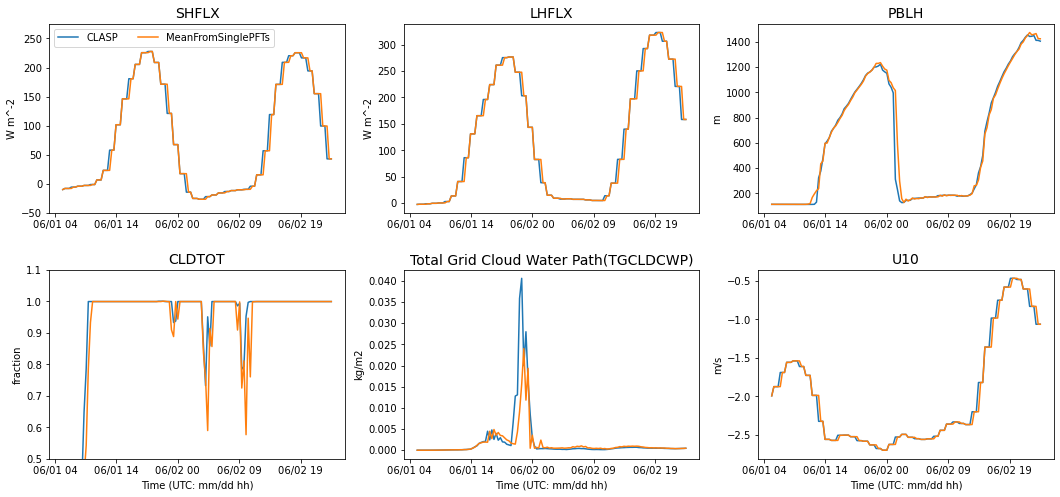

In [63]:
# Format for time on x-axis
myFmt = mdates.DateFormatter('%m/%d %H')


fig, axs = plt.subplots(2,3, figsize=(18, 8))
axs      = axs.ravel()
fig.subplots_adjust(hspace=0.3)

axs[0].plot(times, np.squeeze(camDS_clasp.SHFLX.values),label='CLASP')
axs[0].plot(times, np.squeeze(camDS_fullWeighted.SHFLX.values),label='MeanFromSinglePFTs')
axs[0].legend(ncol=2,loc='upper left')
axs[0].set_title('SHFLX',fontsize=14)
axs[0].set_ylabel('W m^-2')
axs[0].set_ylim([-50,275])
axs[0].xaxis.set_major_formatter(myFmt)
axs[0].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[1].plot(times, np.squeeze(camDS_clasp.LHFLX.values),label='CLASP')
axs[1].plot(times, np.squeeze(camDS_fullWeighted.LHFLX.values),label='MeanFromSinglePFTs')
axs[1].set_title('LHFLX',fontsize=14)
axs[1].set_ylabel('W m^-2')
axs[1].xaxis.set_major_formatter(myFmt)
axs[1].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[2].plot(times, np.squeeze(camDS_clasp.PBLH.values),label='CLASP')
axs[2].plot(times, np.squeeze(camDS_fullWeighted.PBLH.values),label='MeanFromSinglePFTs')
axs[2].set_title('PBLH',fontsize=14)
axs[2].set_ylabel('m')
axs[2].xaxis.set_major_formatter(myFmt)
axs[2].xaxis.set_major_locator(plt.MaxNLocator(5))

axs[3].plot(times, np.squeeze(camDS_clasp.CLDTOT.values),label='CLASP')
axs[3].plot(times, np.squeeze(camDS_fullWeighted.CLDTOT.values),label='MeanFromSinglePFTs')
axs[3].set_title('CLDTOT',fontsize=14)
axs[3].set_ylabel('fraction')
axs[3].xaxis.set_major_formatter(myFmt)
axs[3].xaxis.set_major_locator(plt.MaxNLocator(5))
axs[3].set_xlabel('Time (UTC: mm/dd hh)')
axs[3].set_ylim([0.5,1.1])

axs[4].plot(times, np.squeeze(camDS_clasp.TGCLDCWP.values),label='CLASP')
axs[4].plot(times, np.squeeze(camDS_fullWeighted.TGCLDCWP.values),label='MeanFromSinglePFTs')
axs[4].set_title('Total Grid Cloud Water Path(TGCLDCWP)',fontsize=14)
axs[4].set_ylabel('kg/m2')
axs[4].xaxis.set_major_formatter(myFmt)
axs[4].xaxis.set_major_locator(plt.MaxNLocator(5))
axs[4].set_xlabel('Time (UTC: mm/dd hh)')

axs[5].plot(times, np.squeeze(camDS_clasp.U10.values),label='CLASP')
axs[5].plot(times, np.squeeze(camDS_fullWeighted.U10.values),label='MeanFromSinglePFTs')
axs[5].set_title('U10',fontsize=14)
axs[5].set_ylabel('m/s')
axs[5].xaxis.set_major_formatter(myFmt)
axs[5].xaxis.set_major_locator(plt.MaxNLocator(5))
axs[5].set_xlabel('Time (UTC: mm/dd hh)')



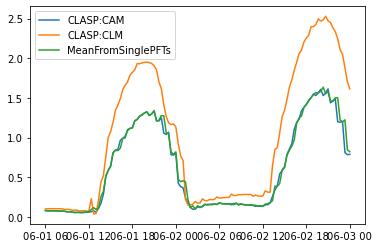

In [78]:
plt.plot(times, np.squeeze(camDS_clasp.UP2_CLUBB.values)[:,-1], label='CLASP: CAM')
plt.plot(times, np.squeeze(clmDS_clasp.UP2_CLUBB.values), label='CLASP: CLM')
plt.plot(times, np.squeeze(camDS_fullWeighted.UP2_CLUBB.values)[:,-1], label='MeanFromSinglePFTs')
plt.legend()


(-0.05, 0.6)

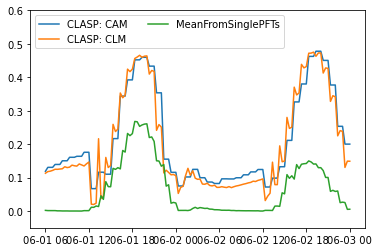

In [85]:
plt.plot(times, np.squeeze(camDS_clasp.THLP2_CLUBB.values)[:,-1], label='CLASP: CAM')
plt.plot(times, np.squeeze(clmDS_clasp.THLP2_CLUBB.values), label='CLASP: CLM')
plt.plot(times, np.squeeze(camDS_fullWeighted.THLP2_CLUBB.values)[:,-1], label='MeanFromSinglePFTs')
plt.legend(loc='upper left',ncol=2)
plt.ylim([-0.05, 0.6])
